# Biologically Plausible Learning Comparision for Medical AI


In [21]:
# imports
import time
import json

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

import os
os.makedirs("learning_results/models", exist_ok=True)
os.makedirs("learning_results/plots", exist_ok=True)

Using device: cpu


### Dataset
 
Wisconsin Dataset: Tabular Data

In [22]:
data = load_breast_cancer()
FEATURE_NAMES = data.feature_names
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

df = X.copy()
df['target'] = y
df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


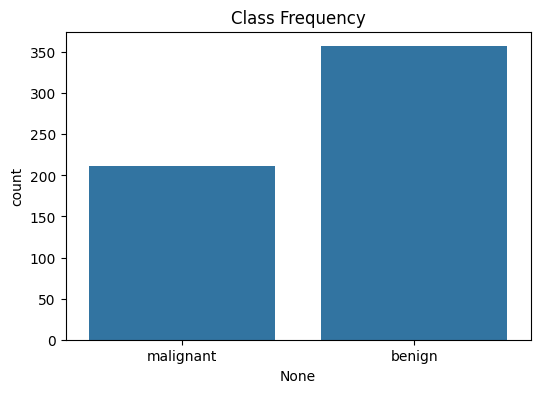

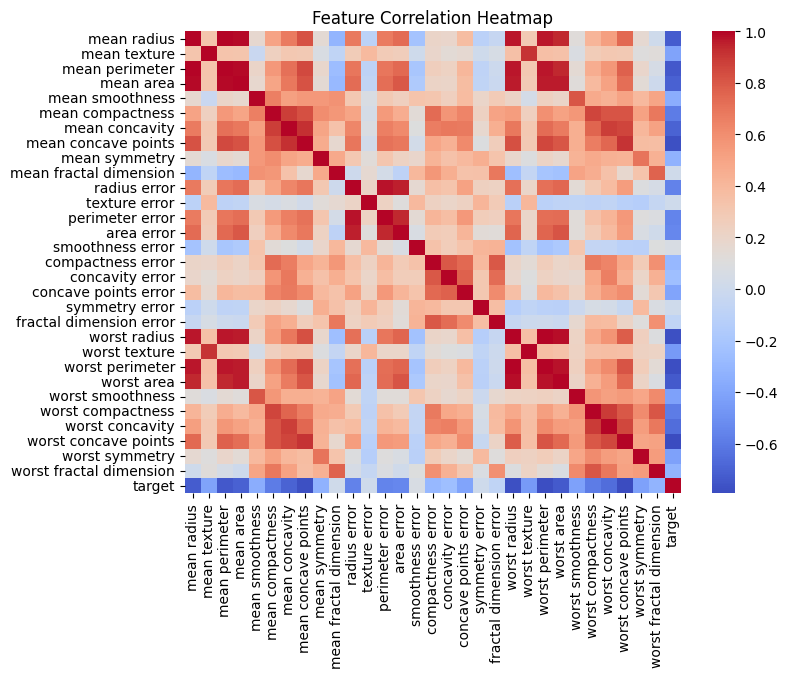

Top correlated features with target:
 worst concave points      -0.793566
worst perimeter           -0.782914
mean concave points       -0.776614
worst radius              -0.776454
mean perimeter            -0.742636
worst area                -0.733825
mean radius               -0.730029
mean area                 -0.708984
mean concavity            -0.696360
worst concavity           -0.659610
mean compactness          -0.596534
worst compactness         -0.590998
radius error              -0.567134
perimeter error           -0.556141
area error                -0.548236
worst texture             -0.456903
worst smoothness          -0.421465
worst symmetry            -0.416294
mean texture              -0.415185
concave points error      -0.408042
mean smoothness           -0.358560
mean symmetry             -0.330499
worst fractal dimension   -0.323872
compactness error         -0.292999
concavity error           -0.253730
fractal dimension error   -0.077972
symmetry error            

In [23]:
plt.figure(figsize=(6,4))
sns.countplot(x=y)
plt.title("Class Frequency")
plt.xticks([0, 1], data.target_names)
plt.show()

corr = df.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

target_corr = corr['target'].drop('target').sort_values(ascending=True)
print("Top correlated features with target:\n", target_corr)

what to do with this info? delete irrelevant features.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# target_corr = X_train.corrwith(y_train)

# threshold = 0.2
# selected_features = target_corr[target_corr.abs() > threshold].index.tolist()
# deleted_features = target_corr[target_corr.abs() <= threshold].index.tolist()

# print(f"Selected features ({len(selected_features)}):\n{selected_features}\n")
# print(f"Deleted features ({len(deleted_features)}):\n{deleted_features}\n")

# X_train = X_train[selected_features]
# X_test = X_test[selected_features]

print(f"Input Features: {X_train.shape[1]}")

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long).to(device)

Input Features: 30


Accuracy was observed to be lower with dropped features. For a small dataset model might benifit from those features for generalisation and might underfit with lesser features.

In deep models a feature that’s weak alone may interact strongly with others. Hard-threshold dropping ignores these multivariate relations and can remove complementary signal. Neural nets also down‑weight redundant inputs through learned weights, so mild redundancy is rarely harmful. On small datasets, aggressive pruning amplifies variance and reduces representational richness.

Also, doing this before train test split MIGHT lead to minor data leakages.


UPDATE: 

Many features -> SHAP vectors have small but positive correlations.

After feature dropping: gradient cosine similarity becomes entirely negative, but increasing: noisy features might be giving same learning signals to both, i.e, not important? with only imp features now the models are learning better but due to different learning rules they are learning differently! BUT: This is less consistent with reported behavior in literature.

Feature attribution became a little more similar. Can likely be due to smaller feature space only

Removed noise might be better for DFA to learn from a more informative subset of features?

## Feedforward Architecture with Backprop

Constant width

In [25]:
input_dim = X_train.shape[1]
hidden_dim = 16
output_dim = 2

print(f"Input Features: {input_dim}, Hidden Dimensions: {hidden_dim}")

class BPNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BPNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.net(x)

Input Features: 30, Hidden Dimensions: 16


Training

Epoch 1/128 | Train Loss: 0.7023, Test Loss: 0.6857, Train Acc: 0.6000, Test Acc: 0.6228
Epoch 8/128 | Train Loss: 0.6704, Test Loss: 0.6555, Train Acc: 0.6264, Test Acc: 0.6316
Epoch 16/128 | Train Loss: 0.6331, Test Loss: 0.6191, Train Acc: 0.6396, Test Acc: 0.6930
Epoch 24/128 | Train Loss: 0.5890, Test Loss: 0.5761, Train Acc: 0.7231, Test Acc: 0.8070
Epoch 32/128 | Train Loss: 0.5357, Test Loss: 0.5235, Train Acc: 0.8044, Test Acc: 0.8684
Epoch 40/128 | Train Loss: 0.4723, Test Loss: 0.4616, Train Acc: 0.8791, Test Acc: 0.9123
Epoch 48/128 | Train Loss: 0.4009, Test Loss: 0.3941, Train Acc: 0.9187, Test Acc: 0.9386
Epoch 56/128 | Train Loss: 0.3294, Test Loss: 0.3282, Train Acc: 0.9363, Test Acc: 0.9386
Epoch 64/128 | Train Loss: 0.2656, Test Loss: 0.2705, Train Acc: 0.9429, Test Acc: 0.9386
Epoch 72/128 | Train Loss: 0.2142, Test Loss: 0.2246, Train Acc: 0.9538, Test Acc: 0.9474
Epoch 80/128 | Train Loss: 0.1750, Test Loss: 0.1899, Train Acc: 0.9604, Test Acc: 0.9561
Epoch 88/128

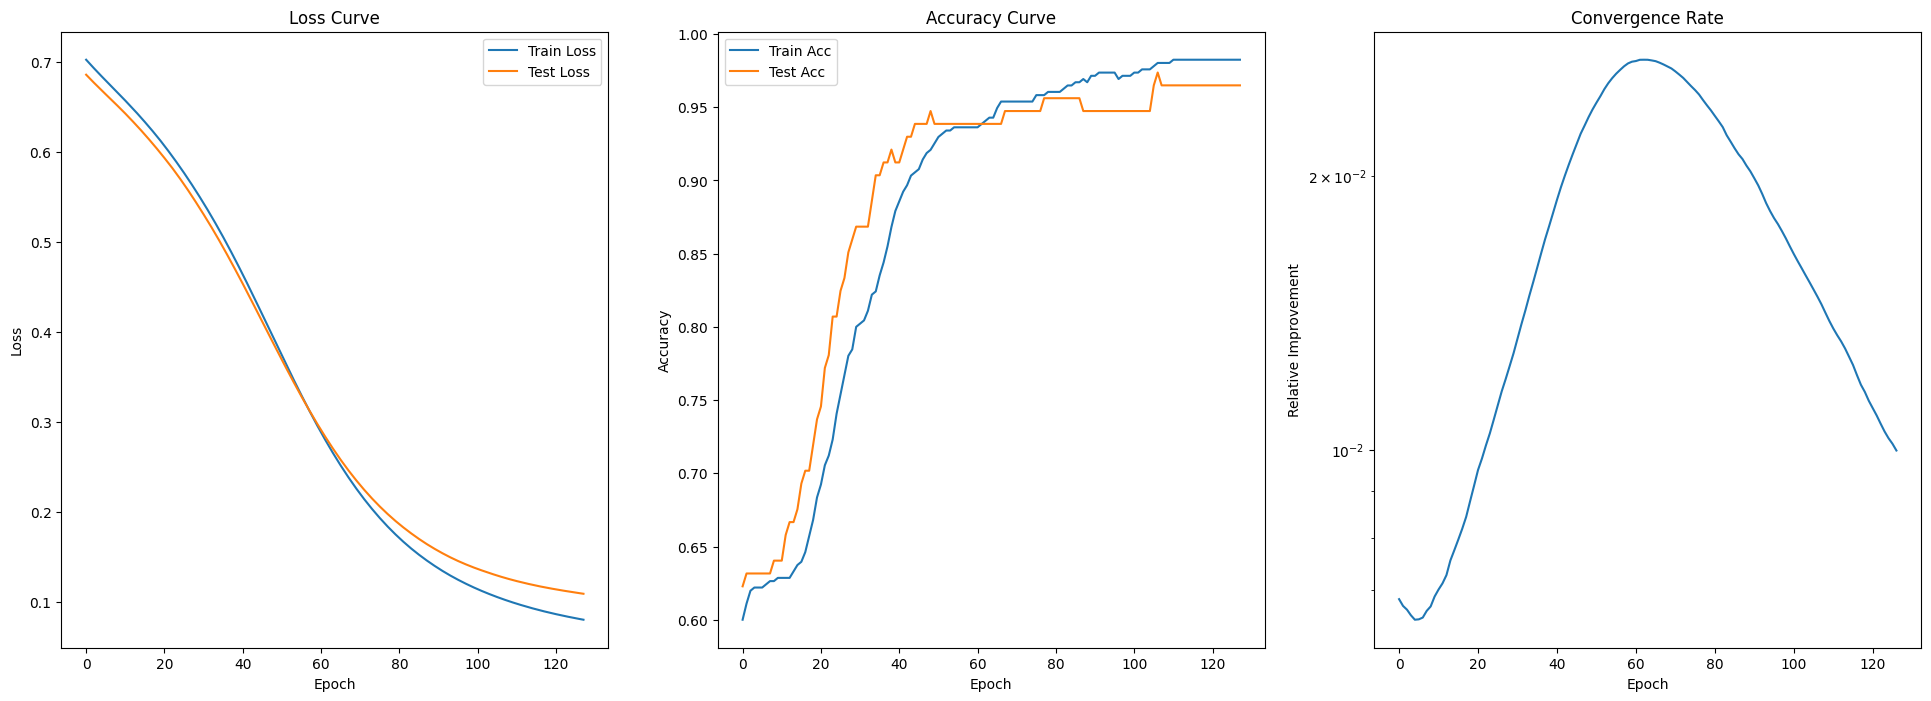

In [26]:
model = BPNN(input_dim, hidden_dim, output_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model_name = "BPNN"
results = {
    "epochs": [],
    "final": {}
}

epochs = 128

train_losses, test_losses = [], []
train_accs, test_accs = [], []

grad_norms = []
weight_updates = []
convergence_rates = []

bp_ref_grads = []   # for cosine similarity

prev_loss = None

start_time = time.perf_counter()
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    # Training
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    
    # Gradients norm and ref
    grads = []
    total_norm = 0
    for p in model.parameters():
        if p.grad is not None:
            grads.append(p.grad.view(-1))
            total_norm += p.grad.norm(2).item() ** 2
    bp_ref_grads.append(torch.cat(grads).detach().cpu().numpy())
    grad_norm = total_norm ** 0.5
    grad_norms.append(grad_norm)
    
    # Update weights
    old_weights = [p.clone() for p in model.parameters()]
    optimizer.step()    
    update_norm = 0
    for old, new in zip(old_weights, model.parameters()):
        update_norm += (new - old).norm(2).item() ** 2
    weight_update_norm = update_norm ** 0.5
    weight_updates.append(weight_update_norm)
    
    # Convergence Rate
    if prev_loss is not None:
        improvement = abs(prev_loss - loss.item())
        rate = improvement / prev_loss if prev_loss > 0 else 0
    else: rate = None
    convergence_rates.append(rate)
    prev_loss = loss.item()

    # Metrics
    preds_train = outputs.argmax(dim=1)
    train_acc = (preds_train == y_train_tensor).float().mean().item()
    train_losses.append(loss.item())
    train_accs.append(train_acc)
    

    # Validation metrics
    model.eval()
    with torch.no_grad():
        test_out = model(X_test_tensor)
        test_loss = criterion(test_out, y_test_tensor).item()
        test_preds = test_out.argmax(dim=1)
        test_acc = (test_preds == y_test_tensor).float().mean().item()
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    

    results["epochs"].append({
        "epoch": epoch + 1,
        "train_loss": loss.item(),
        "test_loss": test_loss,
        "train_acc": train_acc,
        "test_acc": test_acc,
        "grad_norm": grad_norm,
        "weight_update_norm": weight_update_norm,
        "convergence_rate" : rate
    })

    if not epoch or not (epoch+1)%8: 
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {loss.item():.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

end_time = time.perf_counter()
elapsed = end_time - start_time
print(f"\nTraining completed in {elapsed:.2f} seconds")

convergence_rate_bnn = convergence_rates[-1]
print (f"Final Convergence Rate: {convergence_rate_bnn:.4f}, Epoch: {epochs}")

# Plots
plt.figure(figsize=(24, 8))

# Loss curve
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy curve
plt.subplot(1, 3, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(test_accs, label='Test Acc')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Convergence rate
plt.subplot(1, 3, 3)
plt.plot([r for r in convergence_rates if r is not None])
plt.title("Convergence Rate")
plt.xlabel("Epoch")
plt.ylabel("Relative Improvement")
plt.yscale("log")
plt.show()

bp_ref_grads = np.array(bp_ref_grads)
torch.save(model.state_dict(), "learning_results/models/bp_model.pth")

Train and test are close --> no major underfitting or overfitting. Test > Test plausible for small dataset due to higher impact of noise and test dataset being "easier" than train.

Eval

In [27]:
y_true = y_test_tensor.cpu().numpy()
y_pred = test_preds.cpu().numpy()
probs = torch.softmax(test_out, dim=1)[:, 1].cpu().numpy()
report = classification_report(y_true, y_pred, output_dict=True)

print("\nClassification Report:")
print(classification_report(y_true, y_pred))
print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_true, probs):.4f}")
print(f"Final Accuracy: {test_accs[-1]*100:.2f}%")

results["final"] = {
    "training_time": elapsed,
    "f1_score": f1_score(y_true, y_pred),
    "roc_auc": roc_auc_score(y_true, probs),
    "accuracy": test_accs[-1],
    "precision_0": report["0"]["precision"],
    "recall_0": report["0"]["recall"],
    "precision_1": report["1"]["precision"],
    "recall_1": report["1"]["recall"],
    "final_convergence_rate": convergence_rate_bnn,
    "convergence_epoch": epochs,
    "bp_ref_grads": bp_ref_grads.tolist()
}


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95        42
           1       0.99      0.96      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.97      0.96       114
weighted avg       0.97      0.96      0.97       114

F1 Score: 0.9718
ROC AUC: 0.9944
Final Accuracy: 96.49%


Save results

In [28]:
json_path = "learning_results/learning_comparison_results.json"
if os.path.exists(json_path):
    with open(json_path, "r") as f:
        all_results = json.load(f)
else: all_results = {}

all_results[model_name] = results

with open(json_path, "w") as f:
    json.dump(all_results, f, indent=4)

print(f"Results for {model_name} saved to {json_path}")
# print(json.dumps(results, indent=4))

Results for BPNN saved to learning_results/learning_comparison_results.json


---

# FF Architecture with Direct Feedback Alignment 
per Lillicrap et al. (2016).

Same Network

In [29]:
input_dim = X_train.shape[1]
hidden_dim = 16
output_dim = 2

print(f"Input Features: {input_dim}, Hidden Dimensions: {hidden_dim}")

class DFANN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DFANN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.net(x)

Input Features: 30, Hidden Dimensions: 16


Epoch 2/256 | Train Loss: 0.6705, Test Loss: 0.6719, Train Acc: 0.6264, Test Acc: 0.6316
Epoch 3/256 | Train Loss: 0.6691, Test Loss: 0.6705, Train Acc: 0.6264, Test Acc: 0.6316
Epoch 4/256 | Train Loss: 0.6677, Test Loss: 0.6692, Train Acc: 0.6264, Test Acc: 0.6316
Epoch 5/256 | Train Loss: 0.6663, Test Loss: 0.6678, Train Acc: 0.6264, Test Acc: 0.6316
Epoch 6/256 | Train Loss: 0.6648, Test Loss: 0.6664, Train Acc: 0.6264, Test Acc: 0.6316
Epoch 7/256 | Train Loss: 0.6633, Test Loss: 0.6650, Train Acc: 0.6264, Test Acc: 0.6316
Epoch 8/256 | Train Loss: 0.6617, Test Loss: 0.6635, Train Acc: 0.6264, Test Acc: 0.6316
Epoch 9/256 | Train Loss: 0.6601, Test Loss: 0.6620, Train Acc: 0.6264, Test Acc: 0.6316
Epoch 10/256 | Train Loss: 0.6584, Test Loss: 0.6604, Train Acc: 0.6264, Test Acc: 0.6316
Epoch 11/256 | Train Loss: 0.6567, Test Loss: 0.6587, Train Acc: 0.6264, Test Acc: 0.6316
Epoch 12/256 | Train Loss: 0.6549, Test Loss: 0.6569, Train Acc: 0.6264, Test Acc: 0.6316
Epoch 13/256 | Tra

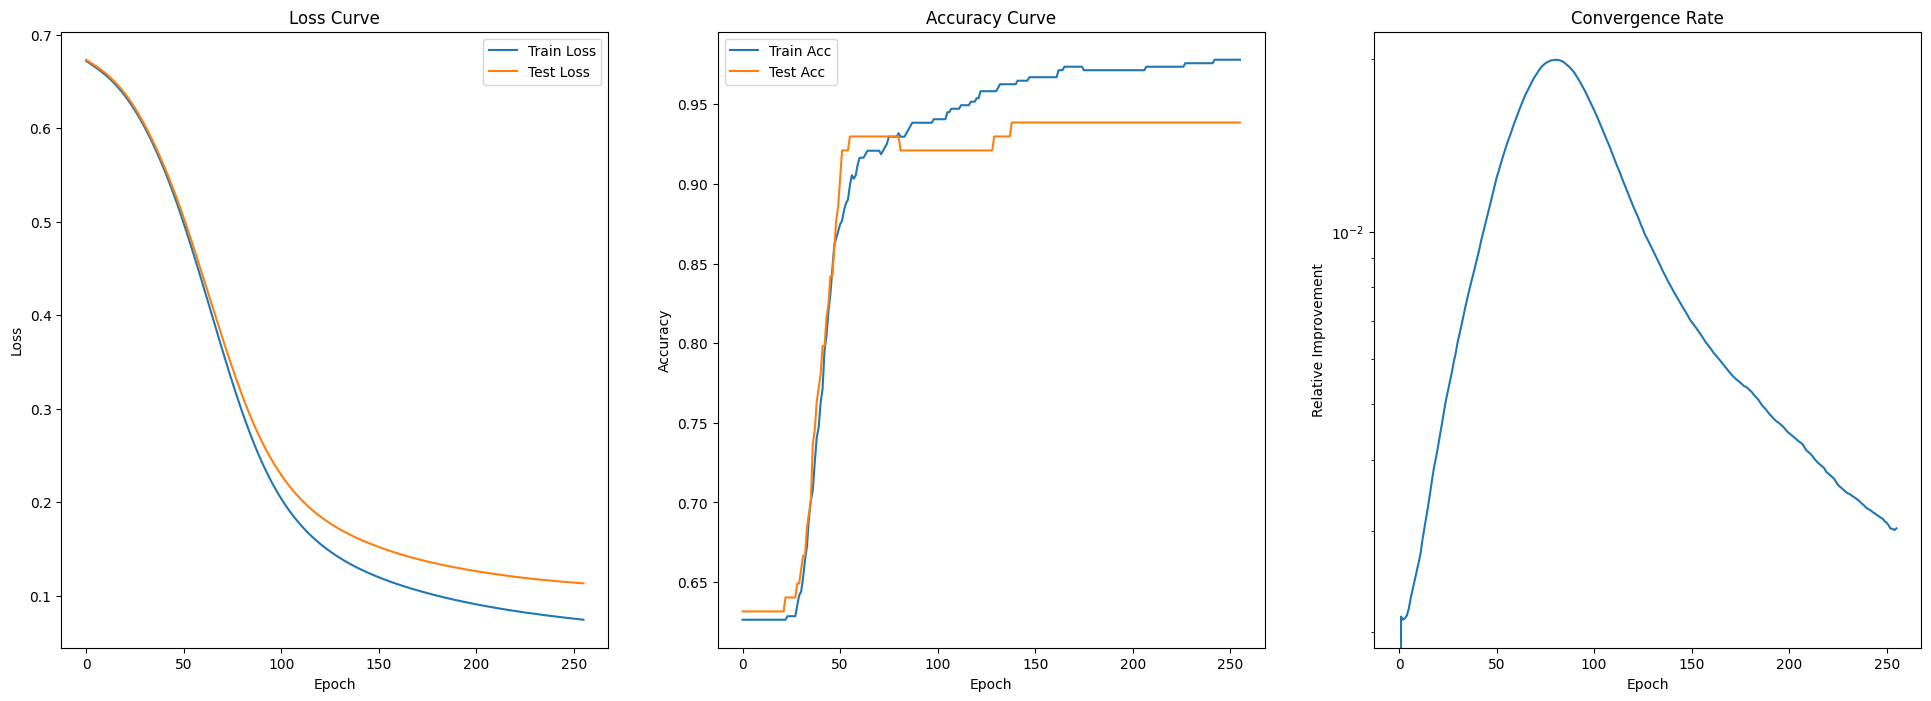

In [30]:
# --- same ---
model = DFANN(input_dim, hidden_dim, output_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# -- same ---


# --- DFA ---
# Initialize fixed random feedback matrices B^l for each hidden layer
# Here, model.net = [Linear1, ReLU, Linear2, ReLU, Linear3] with 3 linears
B = []
linear_layers = [m for m in model.net if isinstance(m, nn.Linear)]
num_layers = len(linear_layers)
for idx, layer in enumerate(linear_layers[:-1]):  # skip last (output) layer
    n_hidden = layer.out_features
    # normalize feedback matrix | To keep the scale of the feedback roughly same regardless of output size
    B_mat = torch.randn(n_hidden, output_dim, device=device) / (output_dim ** 0.5)  # for each hidden layer l, we sample a random matrix B^l ∈ R^{n_l x n_{l+1}} \in N(0,1/sqrt(n_{l+1}))
    B.append(B_mat)

# --- same ---
model_name = "DFANN"
results = {
    "epochs": [],
    "final": {}
}

epochs = 256   # extra to compare convergence
train_losses, test_losses = [], []
train_accs, test_accs = [], []

grad_norms = []
weight_updates = []
convergence_rates = []

cosine_similarities = []

prev_loss = None

start_time = time.perf_counter()
# --- same ---

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    

    # --- Manual forward with activations & pre-activations for DFA --- ~ similar
    activations = [X_train_tensor.to(device)]  # a^0 = x, a^l = \sigma(z^l)
    preacts = []                    # z^l = W^l a^{l-1} + b^l
    for layer in linear_layers:
        x = activations[-1]     # a^{l-1}
        z = layer(x)            #  z^l = W^l a^{l-1} + b^l
        preacts.append(z)
        # apply ReLU for hidden, identity for last
        a = torch.relu(z) if layer is not linear_layers[-1] else z
        activations.append(a)
    outputs = activations[-1]  # logits
    # --- Manual forward with activations & pre-activations for DFA --- ~ similar

    loss = criterion(outputs, y_train_tensor.to(device))
    
    # --- DFA deltas ---
    batch_size = outputs.size(0)
    with torch.no_grad():
        probs = torch.softmax(outputs, dim=1)
        delta_L = probs - torch.nn.functional.one_hot(y_train_tensor.to(device), num_classes=output_dim).float()  # Output layer delta: \delta^L = p - y
    deltas = [None] * num_layers
    deltas[-1] = delta_L
    # hidden layer update
    for l in range(num_layers-1):
        z = preacts[l]
        fb = delta_L @ B[l].T   # direct feedback projection of output loss = delta^L X B^l X; (B X O) X (O X n_l) = (B X n_l); B = batch_size
        delta = fb * (z>0).float()
        deltas[l] = delta   # layer loss delta = deltas^l = fb * ReLU(z^l)
    # --- DFA deltas ---

    # --- Gradient Norm & manual gradients ---
    grads = []
    total_norm = 0.0
    for l, layer in enumerate(linear_layers):
        W = layer.weight
        a_prev = activations[l]
        delta = deltas[l]
        grad_W = (delta.T @ a_prev) / batch_size   # \nabla W^l = \delta^l X a^{l-1} / B
        grad_b = delta.sum(dim=0)                 # \nabla b^l = mean(\delta^l)
        W.grad = grad_W
        layer.bias.grad = grad_b
        grads.append(grad_W.view(-1))  # same order as bp appends
        grads.append(grad_b.view(-1))
        total_norm += grad_W.norm(2).item()**2 + grad_b.norm(2).item()**2
    grad_norm = total_norm**0.5
    grad_norms.append(grad_norm)
    # cosine similarity
    if epoch < 128: 
        dfa_grad = torch.cat(grads).detach().cpu()
        bp_ref_grad = torch.tensor(bp_ref_grads[epoch], dtype=torch.float32) 
        cos_sim = torch.nn.functional.cosine_similarity(
            dfa_grad.unsqueeze(0), bp_ref_grad.unsqueeze(0)
        ).item(); cosine_similarities.append(cos_sim)   
    # --- Gradient Norm ---


    # --- same ---

    # Update weights
    old_weights = [p.clone() for p in model.parameters()]
    optimizer.step()    
    update_norm = 0
    for old, new in zip(old_weights, model.parameters()):
        update_norm += (new - old).norm(2).item() ** 2
    weight_update_norm = update_norm ** 0.5
    weight_updates.append(weight_update_norm)
    
    # Convergence Rate
    cur_loss = loss.item()
    if prev_loss is not None and prev_loss > 0:
        improvement = abs(prev_loss - cur_loss)
        rate = improvement / prev_loss
    else:
        rate = 0.0
    convergence_rates.append(rate)
    prev_loss = cur_loss
    
    # Metrics
    preds_train = outputs.argmax(dim=1)
    train_acc = (preds_train == y_train_tensor.to(device)).float().mean().item()
    train_losses.append(cur_loss)
    train_accs.append(train_acc)
    

    # Validation metrics
    model.eval()
    with torch.no_grad():
        test_out = model(X_test_tensor.to(device))
        test_loss = criterion(test_out, y_test_tensor.to(device)).item()
        test_preds = test_out.argmax(dim=1)
        test_acc = (test_preds == y_test_tensor.to(device)).float().mean().item()
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    

    results["epochs"].append({
        "epoch": epoch + 1,
        "train_loss": cur_loss,
        "test_loss": test_loss,
        "train_acc": train_acc,
        "test_acc": test_acc,
        "grad_norm": grad_norm,
        "weight_update_norm": weight_update_norm,
        "convergence_rate" : rate
    })

    if not epoch == 0 or not (epoch+1)%8:
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {cur_loss:.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")
    
end_time = time.perf_counter()
elapsed = end_time - start_time
print(f"\nTraining completed in {elapsed:.2f} seconds")

convergence_rate_dfa = convergence_rates[-1]
print(f"Final Convergence Rate: {convergence_rate_dfa:.4f}, Epoch: {epochs}")

# Plots
plt.figure(figsize=(24, 8))

# Loss curve
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy curve
plt.subplot(1, 3, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(test_accs, label='Test Acc')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Convergence rate
plt.subplot(1, 3, 3)
plt.plot(convergence_rates)
plt.title("Convergence Rate")
plt.xlabel("Epoch")
plt.ylabel("Relative Improvement")
plt.yscale("log")
plt.show()

torch.save(model.state_dict(), "learning_results/models/dfa_model.pth")

Same eval

In [31]:
y_true = y_test_tensor.cpu().numpy()
y_pred = test_preds.cpu().numpy()
probs = torch.softmax(test_out, dim=1)[:, 1].cpu().numpy()
report = classification_report(y_true, y_pred, output_dict=True)

print("\nClassification Report:")
print(classification_report(y_true, y_pred))
print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_true, probs):.4f}")
print(f"Final Accuracy: {test_accs[-1]*100:.2f}%")\

results["final"] = {
    "training_time": elapsed,
    "f1_score": f1_score(y_true, y_pred),
    "roc_auc": roc_auc_score(y_true, probs),
    "accuracy": test_accs[-1],
    "precision_0": report["0"]["precision"],
    "recall_0": report["0"]["recall"],
    "precision_1": report["1"]["precision"],
    "recall_1": report["1"]["recall"],
    "final_convergence_rate": convergence_rate_dfa,
    "convergence_epoch": epochs,
    "cosine_similarities": cosine_similarities
}


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92        42
           1       0.96      0.94      0.95        72

    accuracy                           0.94       114
   macro avg       0.93      0.94      0.93       114
weighted avg       0.94      0.94      0.94       114

F1 Score: 0.9510
ROC AUC: 0.9931
Final Accuracy: 93.86%


Accuracy varies depending on the random matrix. However, best test results showed accuracy = BNN accuracy, not better

However, test generalises better hence closer to backprop test as compared to train. Because random matrix acts as noise? --> generalised learning!

In [32]:
if os.path.exists(json_path):
    with open(json_path, "r") as f:
        all_results = json.load(f)
else: all_results = {}

all_results[model_name] = results

with open(json_path, "w") as f:
    json.dump(all_results, f, indent=4)

print(f"Results for {model_name} saved to {json_path}")
# print(json.dumps(results, indent=4))

Results for DFANN saved to learning_results/learning_comparison_results.json


### Comparison Plots

Cosine Similarity

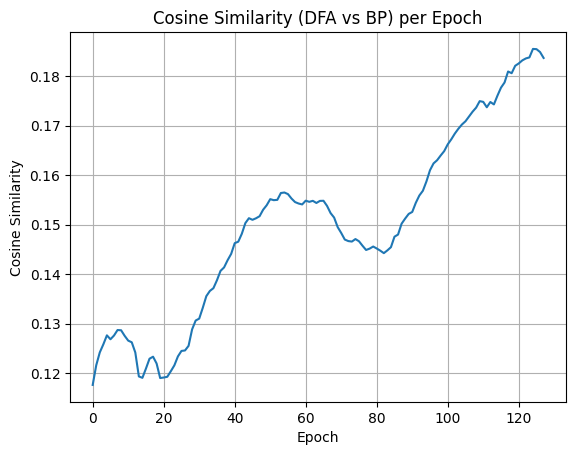

In [33]:
plt.plot(cosine_similarities)
plt.title("Cosine Similarity (DFA vs BP) per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Cosine Similarity")
plt.grid(True)
plt.show()

MORE COHERENT WITH LITERATURE (+ve vals; w/o feature drops)

The cosine similarity between DFA and BP gradients initially rises, indicating early alignment (the alignment effect) where even fixed random feedback leads to meaningful updates. 

Around epoch 10, the similarity sharply declines, reflecting DFA's divergence from BP as it follows its own learning dynamics using fixed feedback paths. 

Despite this drop, the similarity raises as the feedback weakly aligns (~0.16–0.20). 

This pattern highlights that while DFA does not strictly follow BP, it can still learn effectively, supporting the idea that useful representations can emerge without strong gradient alignment, which is coherent with the biological plausibility claims of DFA.

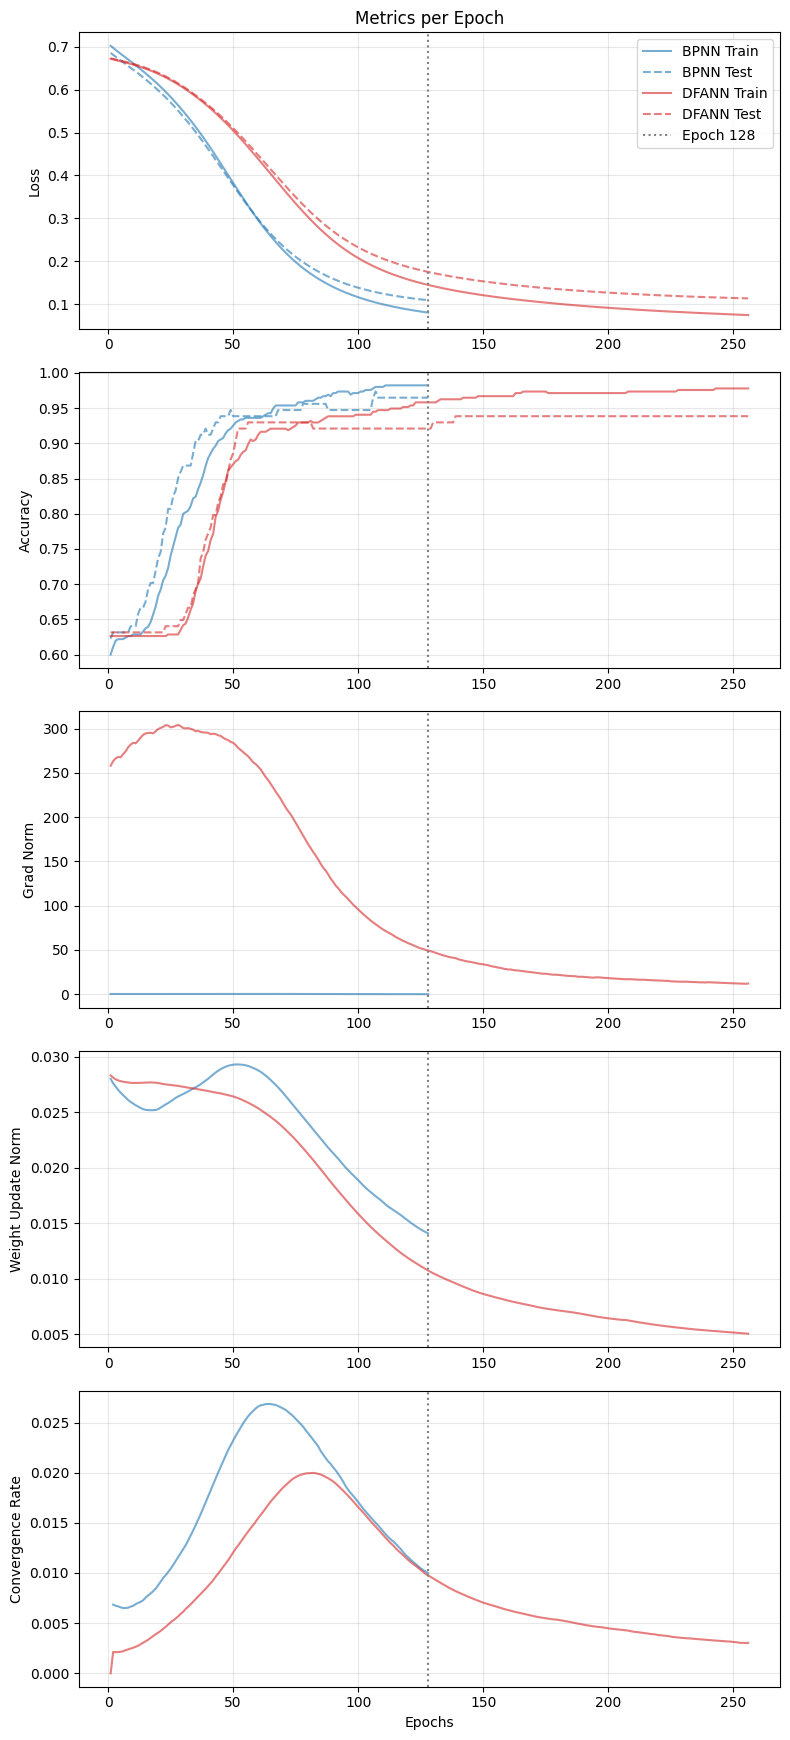


---- Final Metrics Comparison ----
                           BPNN    DFANN
training_time            0.1574   0.4102
f1_score                 0.9718   0.9510
roc_auc                  0.9944   0.9931
accuracy                 0.9649   0.9386
precision_0              0.9318   0.9070
recall_0                 0.9762   0.9286
precision_1              0.9857   0.9577
recall_1                 0.9583   0.9444
final_convergence_rate   0.0100   0.0030
convergence_epoch      128.0000 256.0000


In [34]:
import os
import json
import matplotlib.pyplot as plt
import pandas as pd

# Load the data
with open("learning_results/learning_comparison_results.json", "r") as f:
    data = json.load(f)

models = list(data.keys())  # ['BPNN', 'DFANN']

# Define metric keys
epoch_metrics = [
    ("loss", "train_loss", "test_loss"),
    ("accuracy", "train_acc", "test_acc"),
    ("grad_norm", "grad_norm", None),
    ("weight_update_norm", "weight_update_norm", None),
    ("convergence_rate", "convergence_rate", None)
]

colors = {"BPNN": "tab:blue", "DFANN": "tab:red"}
alpha = 0.6
# Individual plots per metric
for metric_name, train_key, test_key in epoch_metrics:
    fig, ax = plt.subplots(figsize=(8, 5))
    for model in models:
        epochs = [e["epoch"] for e in data[model]["epochs"]]
        # Train curve
        train_vals = [e[train_key] for e in data[model]["epochs"]]
        ax.plot(epochs, train_vals,
                color=colors[model], alpha=alpha,
                linestyle="-", label=f"{model} Train")
        # Test curve
        if test_key:
            test_vals = [e[test_key] for e in data[model]["epochs"]]
            ax.plot(epochs, test_vals,
                    color=colors[model], alpha=alpha,
                    linestyle="--", label=f"{model} Test")
    ax.axvline(x=128, color='gray', linestyle=':', linewidth=1.5, label='Epoch 128')
    ax.set_xlabel("Epochs")
    ax.set_ylabel(metric_name.replace("_", " ").title())
    ax.set_title(f"{metric_name.replace('_', ' ').title()} per Epoch")
    ax.legend()
    ax.grid(alpha=0.3)
    fig.tight_layout()
    fig.savefig(f"learning_results/plots/{metric_name}.png")
    plt.close(fig)

# Combined subplot with vertical line at epoch 128
fig, axes = plt.subplots(len(epoch_metrics), 1, figsize=(8, len(epoch_metrics)*3.5))
for ax, (metric_name, train_key, test_key) in zip(axes, epoch_metrics):
    for model in models:
        epochs = [e["epoch"] for e in data[model]["epochs"]]
        # Train curve
        train_vals = [e[train_key] for e in data[model]["epochs"]]
        ax.plot(epochs, train_vals,
                color=colors[model], alpha=alpha,
                linestyle="-", label=f"{model} Train")
        # Test curve
        if test_key:
            test_vals = [e[test_key] for e in data[model]["epochs"]]
            ax.plot(epochs, test_vals,
                    color=colors[model], alpha=alpha,
                    linestyle="--", label=f"{model} Test")
    ax.axvline(x=128, color='gray', linestyle=':', linewidth=1.5, label='Epoch 128' if ax is axes[0] else None)
    ax.set_ylabel(metric_name.replace("_", " ").title())
    ax.grid(alpha=0.3)
    if ax is axes[0]:
        ax.set_title("Metrics per Epoch")
        ax.legend(loc="upper right")
    if ax is axes[-1]:
        ax.set_xlabel("Epochs")
fig.tight_layout()
plt.show()

# Final metric table
final_metrics_keys = [
    "training_time", "f1_score", "roc_auc", "accuracy",
    "precision_0", "recall_0", "precision_1", "recall_1",
    "final_convergence_rate", "convergence_epoch"
]

final_data = {
    model: [data[model]["final"].get(k, None) for k in final_metrics_keys]
    for model in models
}

df = pd.DataFrame(final_data, index=final_metrics_keys)
print("\n---- Final Metrics Comparison ----")
print(df.to_string(float_format="%.4f"))

### Interpretation

LOSS CURVE:  DFA’s random feedback path delivers a noisier, lower‑magnitude learning signal, so optimization is slower. But it ultimately reaches comparable loss, which shows the network can still discover a useful representation even without true backpropagation.

ACCURACY CURVE: Although DFANN catches up, it requires more training. This is because backprop aligns each hidden weight update directly with downstream error, whereas DFA injects error via a fixed random projection which must, over time, perhaps, maybe, should align the hidden features with the target.

GRAD NORM: Random feedback matrices produce large, inconsistent gradient magnitudes early on, which gradually shrink as the network weights learn to use these noisy signals. Backprop’s more precise gradients are lower‑variance, avoiding that initial spike.

WEIGHT NORM: Despite very different gradient sources, Adam’s adaptive moments normalize update scales so that the actual parameter moves remain roughly comparable. This helps DFANN avoid divergence even under noisy gradients. Without an adaptive optimiser the noisier dfa gradients would blow-up or vanish.

CONVERGENCE RATE: BP achieves most of its progress early on, then plateaus. DFA—lacking exact gradient alignment—has a delayed, stretched‑out learning curve.

RECALL/PERCISION/ACC: for both classes under DFANN indicates a small loss in decision‑boundary sharpness and accuracy.

!!! The inherent noise in DFA’s feedback can act like a regulariser, smoothing the loss landscape and sometimes improving generalisation.

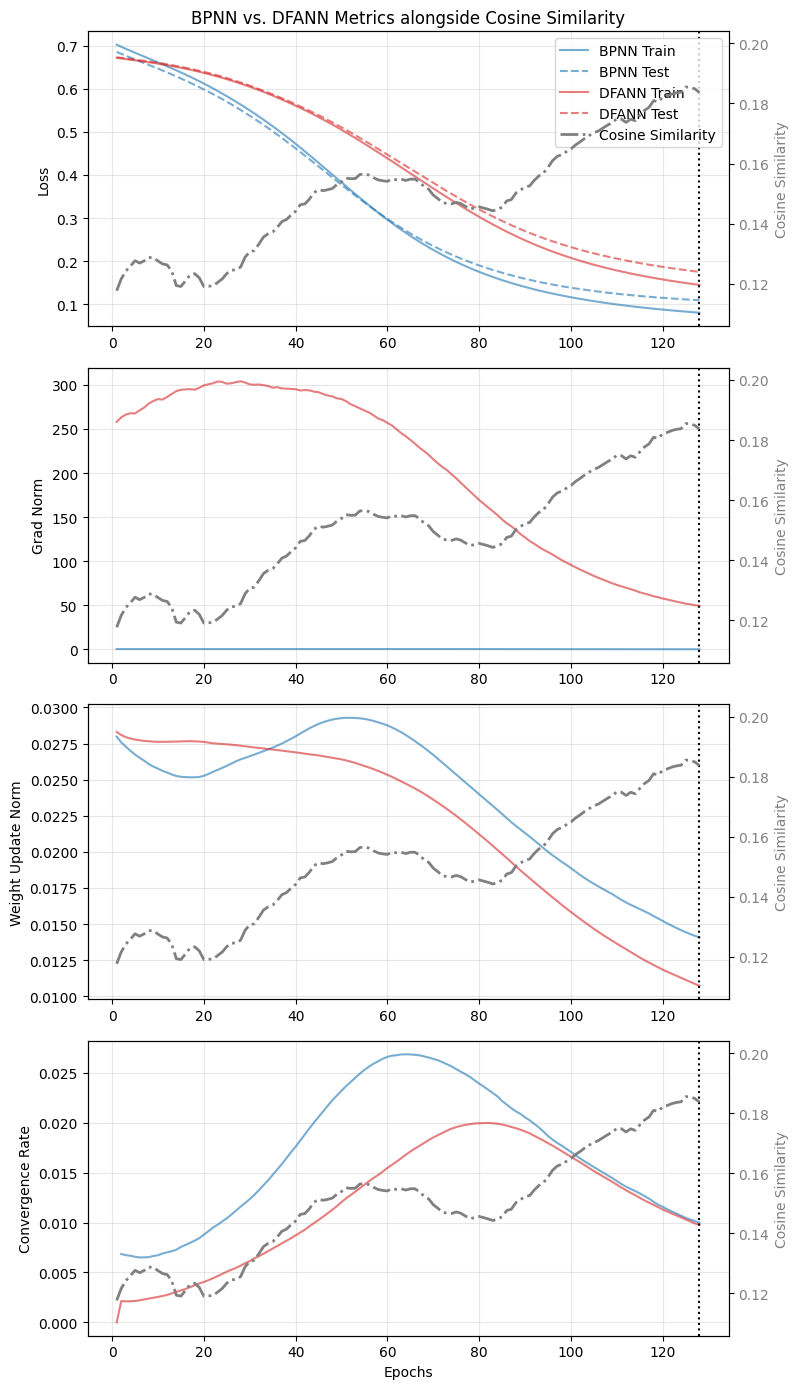

In [35]:
epoch_metrics = [("loss", "train_loss", "test_loss"), ("grad_norm", "grad_norm", None), ("weight_update_norm", "weight_update_norm", None), ("convergence_rate", "convergence_rate", None)]
filtered_epochs = {
    model: [e for e in data[model]["epochs"] if e["epoch"] <= 128]
    for model in models
}; epochs = [e["epoch"] for e in filtered_epochs["DFANN"]]

cos_vals = data["DFANN"]["final"]["cosine_similarities"]

fig, axes = plt.subplots(len(epoch_metrics), 1, figsize=(8, len(epoch_metrics) * 3.5))
for ax, (metric_name, train_key, test_key) in zip(axes, epoch_metrics):
    for model in models:
        train_vals = [e[train_key] for e in filtered_epochs[model]]
        ax.plot(epochs, train_vals, label=f"{model} Train", color=colors[model], linestyle="-", alpha=alpha)

        if test_key:
            test_vals = [e[test_key] for e in filtered_epochs[model]]
            ax.plot(epochs, test_vals, label=f"{model} Test", color=colors[model], linestyle="--", alpha=alpha)

    ax2 = ax.twinx()
    ax2.plot(epochs, cos_vals, color="gray", linestyle="-.", linewidth=2, label="Cosine Similarity")
    ax2.set_ylabel("Cosine Similarity", color="gray")
    ax2.tick_params(axis='y', labelcolor="gray")
    ax2.set_ylim(min(cos_vals)*0.9, max(cos_vals)*1.1)

    ax.axvline(x=128, color='black', linestyle=':', linewidth=1.5)
    ax.set_ylabel(metric_name.replace("_", " ").title())
    ax.grid(alpha=0.3)

    if ax is axes[0]:
        ax.set_title("BPNN vs. DFANN Metrics alongside Cosine Similarity")
        lines1, labels1 = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

axes[-1].set_xlabel("Epochs")
plt.tight_layout()
plt.savefig("learning_results/plots/cosine_similarity.png", bbox_inches='tight') 
plt.show()

Loss: The early peak in cosine similarity aligns with the initial drop in DFA loss, supporting the idea that early alignment with BP helps DFA get started. As the similarity declines, DFA continues to learn but at a slower rate. Gradient alignment helps early training, DFA can still reduce loss later even with unaligned updates.


Grad Norm: The cosine similarity curve follows an opposite trend to the DFA gradient norm. When the gradients are large and noisy, similarity is low. Once the DFA gradients shrink and stabilize, the similarity slowly increases. This implies that high-magnitude, noisy gradients in DFA tend to point in directions that differ more from BP.


Weight update norms: The cosine similarity curve dips when DFA’s update norm spikes, reflecting more misaligned learning directions. However, overall update norms converge, showing that both models adjust weights at similar scales despite different gradient directions.


Convergence rate: Even when gradients are misaligned, DFA continues to improve. This shows that DFA can still converge well using fixed feedback, without needing gradients that closely match BP. But is it the optimizer or the learning dynamics?

---

## What does the model learn? Feature attribution analysis: SHAP

In [36]:
import shap
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings("ignore")

# ----- Load models -----
bp_model = BPNN(input_dim, hidden_dim, output_dim).cpu()
bp_model.load_state_dict(torch.load("learning_results/models/bp_model.pth"))
bp_model.eval()

dfa_model = DFANN(input_dim, hidden_dim, output_dim).cpu()
dfa_model.load_state_dict(torch.load("learning_results/models/dfa_model.pth"))
dfa_model.eval()

# ----- 

X_test_shap = torch.tensor(X_test, dtype=torch.float32)     # input

# SHAP explanations
explainer_bp = shap.DeepExplainer(bp_model, X_test_shap)
explainer_dfa = shap.DeepExplainer(dfa_model, X_test_shap)

shap_vals_bp = explainer_bp.shap_values(X_test_shap)
shap_vals_dfa = explainer_dfa.shap_values(X_test_shap)


print(shap_vals_bp.shape, shap_vals_dfa.shape)

(114, 30, 2) (114, 30, 2)


In [37]:
# ----- Extract class 0 attributions -----
bp_attr = shap_vals_bp[:, :, 0]
dfa_attr = shap_vals_dfa[:, :, 0] # (num_samples, num_features)

# Attribution Stats

# Global Spearman Correlation
mean_bp = np.mean(np.abs(bp_attr), axis=0)
mean_dfa = np.mean(np.abs(dfa_attr), axis=0)
global_spearman, pval = spearmanr(mean_bp, mean_dfa)

# Mean Cosine Similarity
cosines = []
for i in range(len(bp_attr)):
    a = bp_attr[i].reshape(1, -1)
    b = dfa_attr[i].reshape(1, -1)
    cos = cosine_similarity(a, b)[0, 0]
    cosines.append(cos)
mean_cosine = np.mean(cosines)

# Top-k Overlap
def topk_overlap(a, b, k):
    top_a = set(np.argsort(np.abs(a))[-k:])
    top_b = set(np.argsort(np.abs(b))[-k:])
    return len(top_a & top_b) / k
k = 8
overlaps = [topk_overlap(bp_attr[i], dfa_attr[i], k) for i in range(len(bp_attr))]
mean_topk_overlap = np.mean(overlaps)


print("---- SHAP Attribution Comparison ---\n")
print(f"Global Spearman Correlation, p-value:  {global_spearman:.4f}, {pval:.4f}")
print(f"Mean Cosine Similarity:                {mean_cosine:.4f}")
print(f"Mean Top-{k} Overlap:                    {mean_topk_overlap:.4f}")

---- SHAP Attribution Comparison ---

Global Spearman Correlation, p-value:  0.7326, 0.0000
Mean Cosine Similarity:                0.8984
Mean Top-8 Overlap:                    0.6743


The two models agree somewhat on what features matter globally, but there are notable differences.

High similarity in instance-level feature attributions, i.e., for most individual predictions, the direction and strength of SHAP values from both models are similar?? Also might indicate that many features are irrelavant to MOST decisions, thus not assignmed significatn weight by any model -> similar grads.

On average, ~ 55% of the top-8 most important features overlap per instance. Again, partial global agreement.

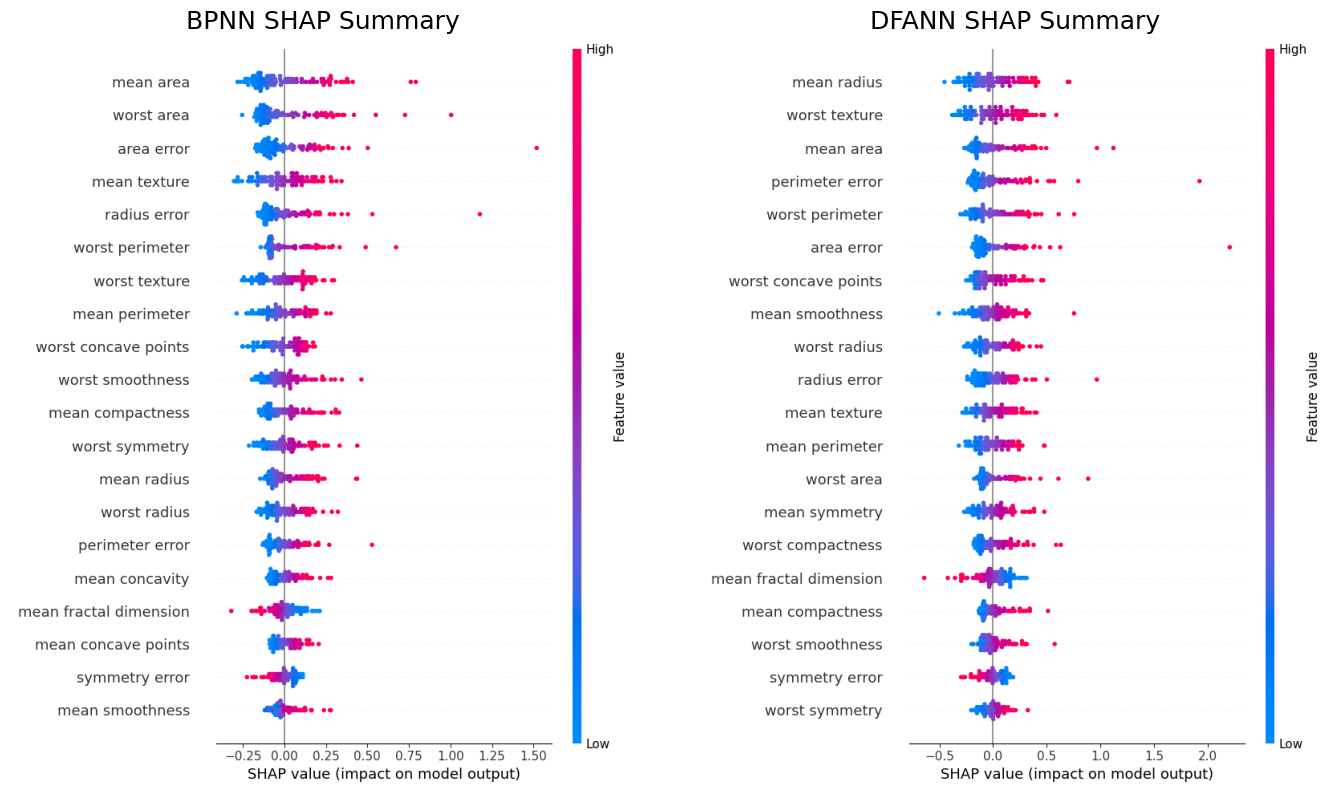

In [38]:
# SHAP plots
shap.summary_plot(bp_attr, features=X_test, feature_names=FEATURE_NAMES, show=False)
plt.savefig("learning_results/plots/bp_shap.png", bbox_inches='tight')
plt.close()

shap.summary_plot(dfa_attr, features=X_test, feature_names=FEATURE_NAMES, show=False)
plt.savefig("learning_results/plots/df_shap.png", bbox_inches='tight')
plt.close()

import matplotlib.image as mpimg
fig, axes = plt.subplots(1, 2, figsize=(14, 8))
axes[0].imshow(mpimg.imread("learning_results/plots/bp_shap.png"))
axes[0].axis('off')
axes[0].set_title("BPNN SHAP Summary", fontsize=18)

axes[1].imshow(mpimg.imread("learning_results/plots/df_shap.png"))
axes[1].axis('off')
axes[1].set_title("DFANN SHAP Summary", fontsize=18)

plt.tight_layout()
plt.savefig("learning_results/plots/combined_shap_summary.png", bbox_inches='tight') 
plt.show()

mal -> right, ben -> left

colour = feaeture val

individual dots = individual sample analysis

DFA appears to give more importance to shape and fractal dimension features, 

while BP leans toward area and texture metrics.

Distribution of SHAP values is also slightly wider for BP on top features, suggesting stronger reliance on a few dominant features, as compared to more evenly distributed DFA.

DFA provides no gradient-based credit assignment through hidden layers, which can lead to more distributed feature usage instead of overfitting to a single strong feature.

In [39]:
bp_ranked_indices = np.argsort(-np.mean(np.abs(bp_attr), axis=0))
dfa_ranked_indices = np.argsort(-np.mean(np.abs(dfa_attr), axis=0))

# Top 10 features
top_10_bp = bp_ranked_indices[:10]
top_10_dfa = dfa_ranked_indices[:10]

bp_rank_map = {idx: rank for rank, idx in enumerate(bp_ranked_indices)}
dfa_rank_map = {idx: rank for rank, idx in enumerate(dfa_ranked_indices)}

print("\n---- Top-10 Cross-Ranking Comparison ----\n")
print(f"{'Rank':<4} | {'BPNN Feature':<23} {'DFANN Rank':<13} \t||\t {'DFANN Feature':<26} {'BPNN Rank':<11}")
print("-" * 100)
for i in range(10):    
    bp_feat_name = FEATURE_NAMES[top_10_bp[i]]
    dfa_feat_name = FEATURE_NAMES[top_10_dfa[i]]
    
    dfa_rank_of_bp = dfa_rank_map[top_10_bp[i]] + 1
    bp_rank_of_dfa = bp_rank_map[top_10_dfa[i]] + 1

    print(f"{i+1:<4} | {bp_feat_name:<27} {dfa_rank_of_bp:<10} \t||\t {dfa_feat_name:<29} {bp_rank_of_dfa:<10}")


---- Top-10 Cross-Ranking Comparison ----

Rank | BPNN Feature            DFANN Rank    	||	 DFANN Feature              BPNN Rank  
----------------------------------------------------------------------------------------------------
1    | mean area                   3          	||	 mean radius                   13        
2    | worst area                  13         	||	 worst texture                 7         
3    | area error                  6          	||	 mean area                     1         
4    | mean texture                11         	||	 perimeter error               15        
5    | radius error                10         	||	 worst perimeter               6         
6    | worst perimeter             5          	||	 area error                    3         
7    | worst texture               2          	||	 worst concave points          9         
8    | mean perimeter              12         	||	 mean smoothness               20        
9    | worst concave points   

Features like worst texture, mean area, and worst perimeter appear high on both lists.

Clinically coherent, but diverging features.

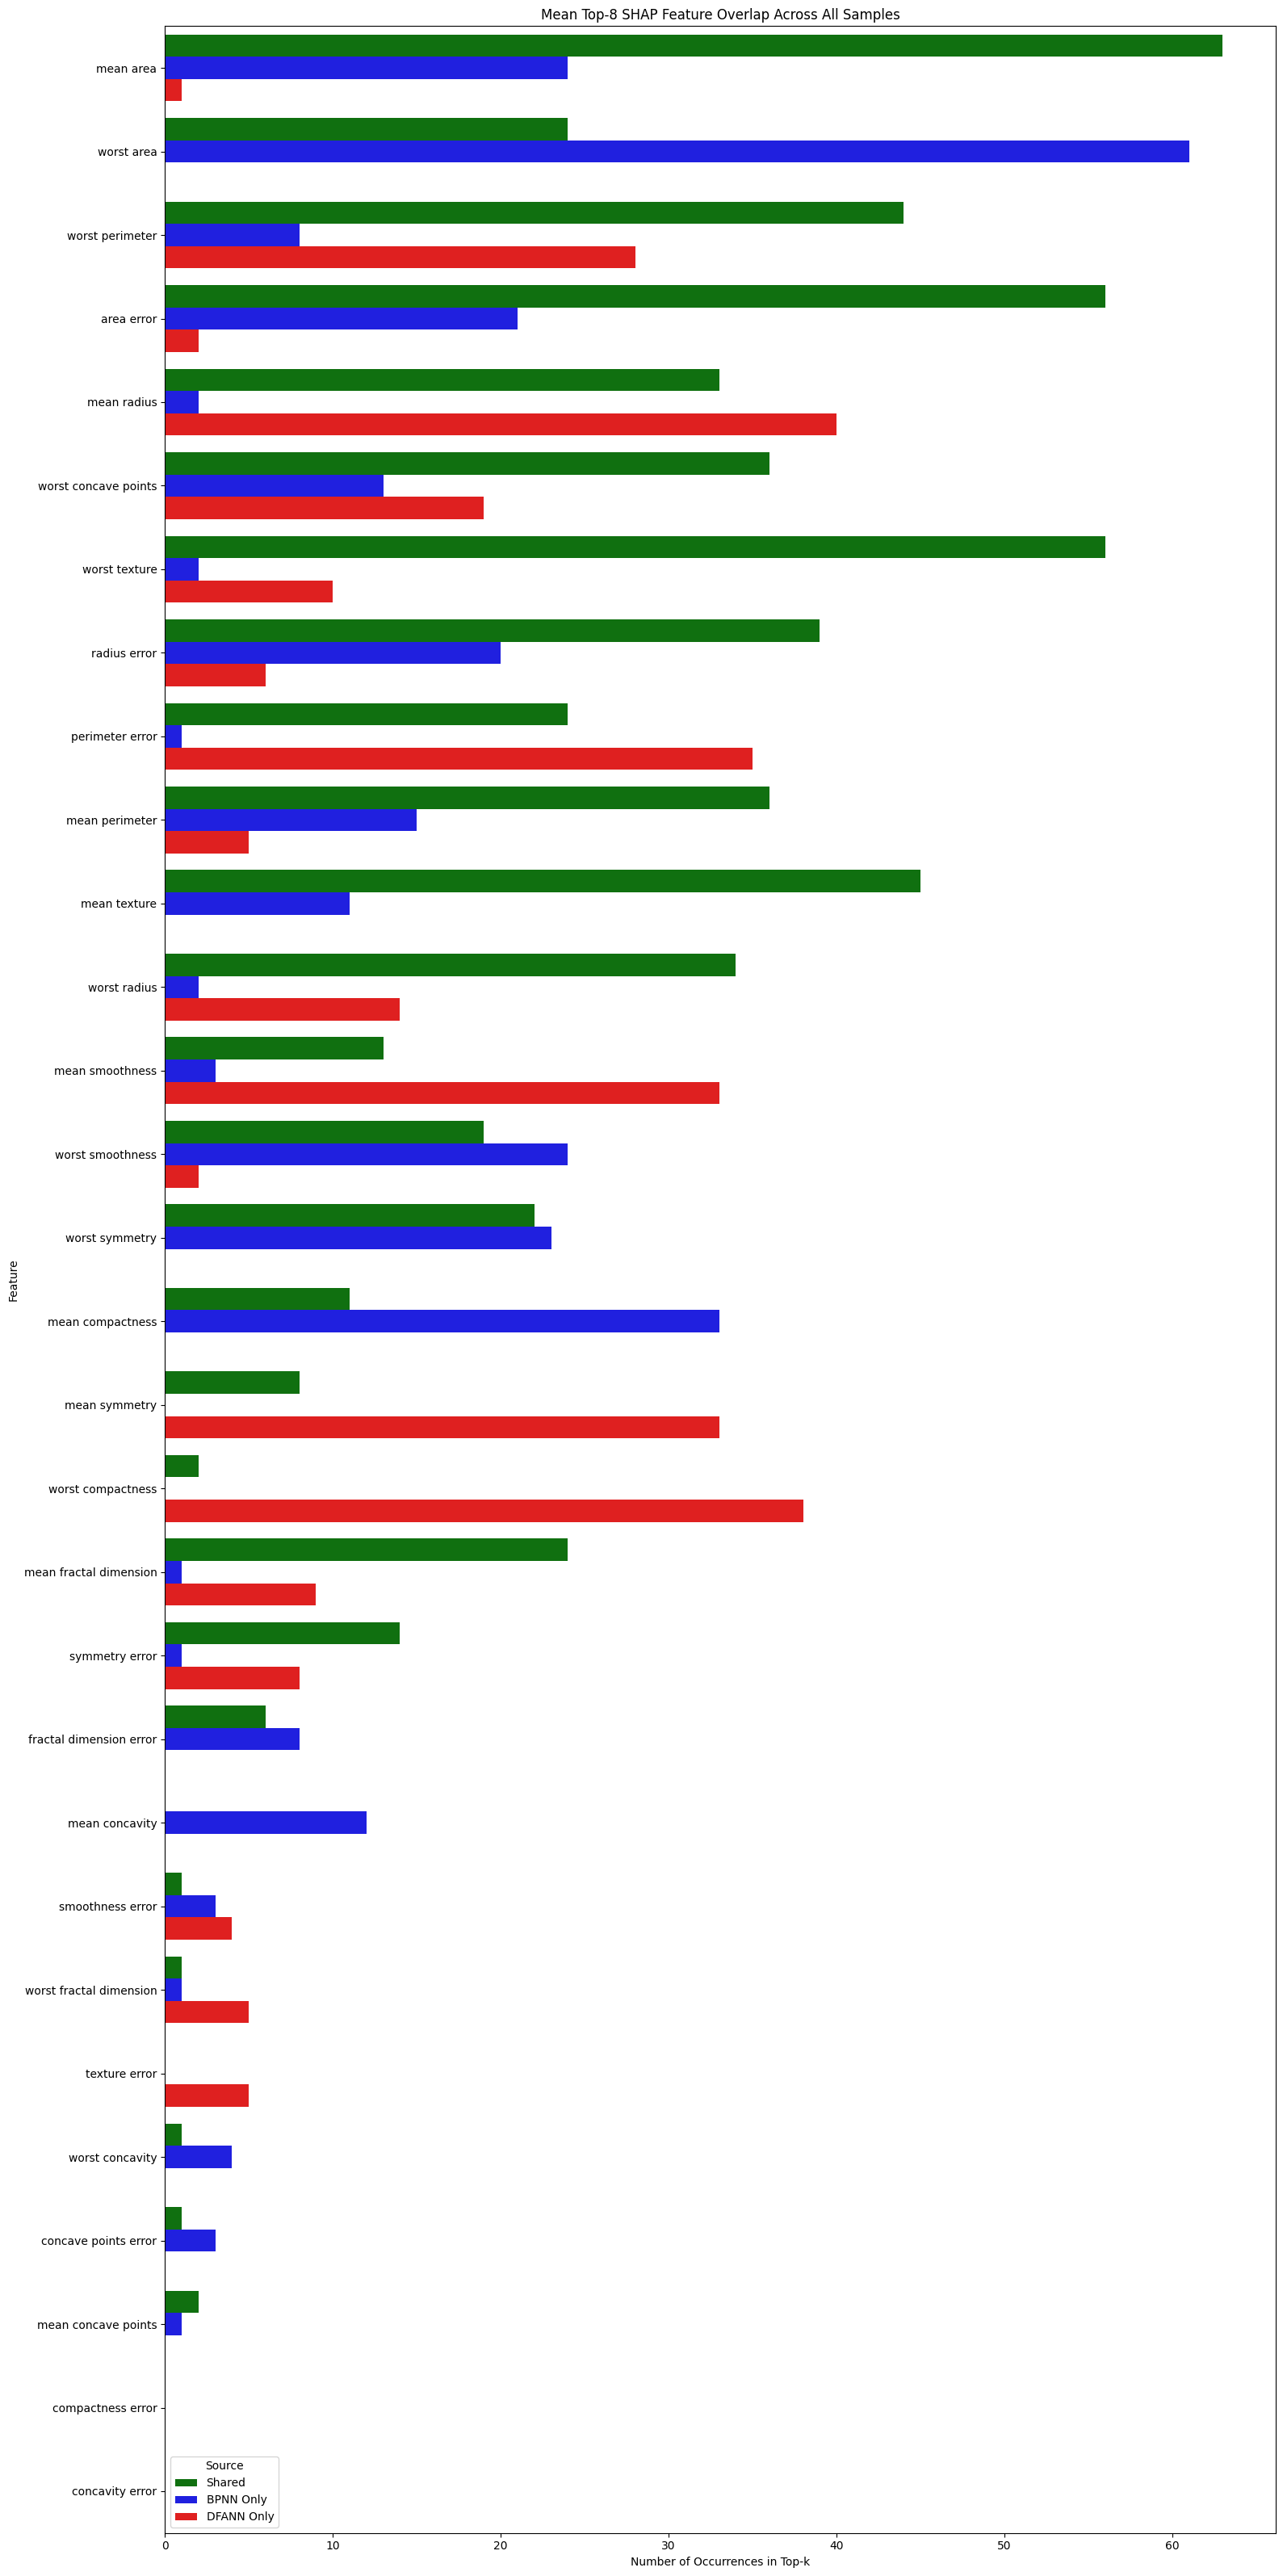

In [40]:
n_samples, n_features = bp_attr.shape
feature_counts = {fn: {"Shared": 0, "BPNN Only": 0, "DFANN Only": 0} for fn in FEATURE_NAMES}

for i in range(n_samples):
    topk_bp = set(np.argsort(np.abs(bp_attr[i]))[-k:])
    topk_dfa = set(np.argsort(np.abs(dfa_attr[i]))[-k:])

    shared = topk_bp & topk_dfa
    only_bp = topk_bp - topk_dfa
    only_dfa = topk_dfa - topk_bp

    for idx in shared:
        feature_counts[FEATURE_NAMES[idx]]["Shared"] += 1
    for idx in only_bp:
        feature_counts[FEATURE_NAMES[idx]]["BPNN Only"] += 1
    for idx in only_dfa:
        feature_counts[FEATURE_NAMES[idx]]["DFANN Only"] += 1

data = []
for feat, counts in feature_counts.items():
    for source, count in counts.items():
        data.append((feat, source, count))
df = pd.DataFrame(data, columns=["Feature", "Source", "Count"])
df["Total"] = df.groupby("Feature")["Count"].transform("sum")
df = df.sort_values("Total", ascending=False)

plt.figure(figsize=(16, 32))
sns.barplot(data=df, y="Feature", x="Count", hue="Source", palette={
    "Shared": "green",
    "BPNN Only": "blue",
    "DFANN Only": "red"
})
plt.title(f"Mean Top-{k} SHAP Feature Overlap Across All Samples")
plt.xlabel("Number of Occurrences in Top-k")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig("learning_results/plots/top_k_shap_overlap.png", bbox_inches='tight')
plt.show()

Apparently,

DFA relies more on texture/shape detail

BPNN leans more on area and compactness metrics

Important features in both models match known breast cancer indicators: Area / Radius / Perimeter / Texture / Smoothness

Some DFA-only features, such as smoothness error, concave points error may reflect model sensitivity to shape changes compared to BP learning area and size changes.

Correlate with domain-specialist to get something like:

- Area-related features (mean/worst area, perimeter) are typically strong indicators of malignancy, as cancerous tumors often grow larger and irregular.

- Texture and fractal dimension reflect microscopic irregularity and structural complexity: Malignant tissues often have disorganized cell structures --> captured by fractal dimension, texture, smoothness, etc.

Some might say, DFA’s attention to shape, texture, and fractal features could reflect clinically relevant patterns better than BP’s size bias.
<br>

| Aspect              | BP                           | DFA                          |
| ------------------------ | ----------------------------------- | ------------------------------------ |
| **Focuses on**           | Tumor size and intensity variation  | Tumor shape irregularities           |
| **SHAP profile**         | Strong emphasis on few features     | Broader spread across features       |
| **Interpretability**     | Simpler (more sparse)               | Richer but possibly noisier          |
| **Clinical soundness**   | Strong due to use of area/perimeter | Also sound; shape/fractal     |
| **Generalisation** | May overfit few features            | Could be more stable under distribution shift. Broader attribution may act like implicit regularisation. |


This might be useful for:

- Deploying model to new clinical sites

- Dealing with small shifts in measurement protocols

- Long-term deployment where data drift may occur

### Why does DFA behave this way?

Because:

    - Feedback alignment in DFA trains each layer using random local feedback rather than backpropagated error.

    - This looser supervision can cause the model to rely on a broader set of internal representations.

    - That, in turn, leads to more distributed feature attributions, i.e., richer, but potentially less sharply focused on the most optimal features. This may act like implicit regularisation leading to better generalisation and robustness?